# <center>Livrable 2</center>
___

## Modules import

In [2]:
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from ipywidgets import IntProgress
from IPython.display import display

## Create the ``Cities`` class

In [3]:
class Cities:
    cities = []

    def __init__(self, nb_nodes: int, x_range: tuple[int, int], y_range: tuple[int, int], seed: int=None) -> None:
        self.x_range = x_range
        self.y_range = y_range
        if seed:
            random.seed(seed)
        else:
            seed = int(str(time.time()).split('.')[1][-4:])
            random.seed(seed)
        used_coordinates = set()

        while len(self.cities) < nb_nodes:
            x = random.randint(self.x_range[0], self.x_range[1])
            y = random.randint(self.y_range[0], self.y_range[1])

            if (x, y) not in used_coordinates:
                used_coordinates.add((x, y))
                self.cities.append((len(self.cities) + 1, x, y))

    def calculateDistance(self, city_1: int, city_2: int) -> float:
        city_1 = self.cities[city_1 - 1]
        city_2 = self.cities[city_2 - 1]
        return ((city_1[1] - city_2[1])**2 + (city_1[2] - city_2[2])**2)**0.5

    def calculateDistanceFromCenter(self, city: int) -> float:
        city = self.cities[city - 1]
        return ((city[1] - self.x_range[1]/2)**2 + (city[2] - self.y_range[1]/2)**2)**0.5

    def getCenterCity(self) -> tuple[int, int, int]:
        distances = [(point, self.calculateDistanceFromCenter(point[0])) for point in self.cities]
        return min(distances, key=lambda x: x[1])[0]

## Create the ``Graph`` class

In [4]:
class Graph:
    def __init__(self, data: tuple[int, int, int], title: str="", xlabel: str="X Coordinate", ylabel: str="Y Coordinate", figsize: tuple[int, int]=(10, 10)) -> None:
        self.data = data
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.figsize = figsize

    def scatter_plot(self, **kwargs) -> None:
        plt.figure(figsize=self.figsize)
        second_kwargs = {}
        if kwargs.get("arrow") != None:
            second_kwargs["arrow"] = kwargs["arrow"]
            kwargs.pop("arrow")
        plt.scatter([x[1] for x in self.data], [x[2] for x in self.data], **kwargs)
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        for i, txt in enumerate(self.data):
            plt.annotate(txt[0], (txt[1], txt[2]))
        if second_kwargs.get("arrow") != None:
            num_clusters = len(second_kwargs["arrow"])
            colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))
            for cluster_idx, cycle in enumerate(second_kwargs["arrow"]):
                color = colors[cluster_idx]
                for i in range(len(cycle)):
                    start = cycle[i]
                    end = cycle[(i + 1) % len(cycle)]
                    arrow = patches.FancyArrowPatch((start[1], start[2]), (end[1], end[2]), mutation_scale=20, arrowstyle='-|>', color=color)
                    plt.gca().add_patch(arrow)
        plt.show()

## Generate cities and display graph

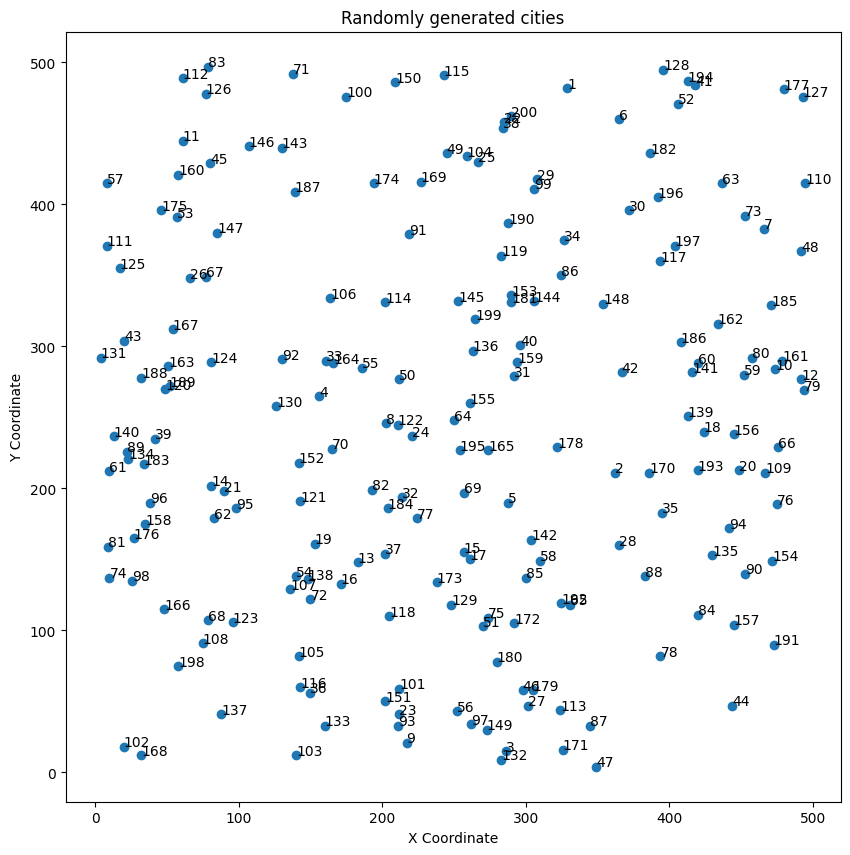

In [5]:
nb_nodes = 200
x_range = (0, 500)
y_range = (0, 500)

data = Cities(nb_nodes, x_range, y_range)

center_city = data.getCenterCity()

graph = Graph(data=data.cities, title="Randomly generated cities")
graph.scatter_plot()

## Create the ``kMeansClusters`` class

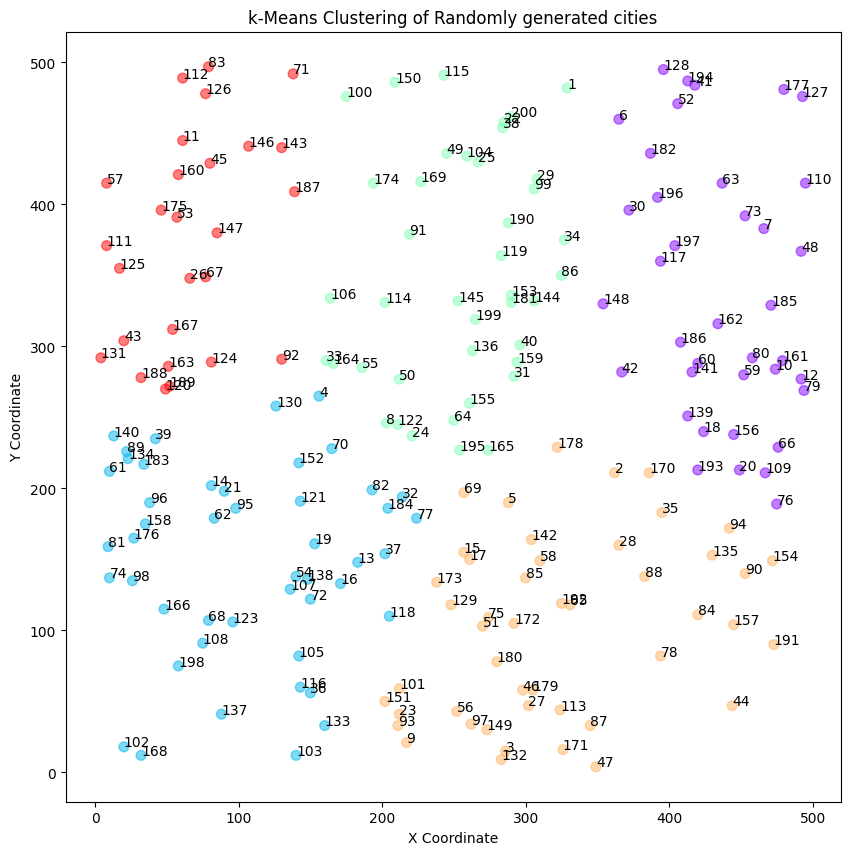

In [6]:
class kMeansClusters:
    def __init__(self, k: int, data: tuple[int, int, int]) -> None:
        self.k = k
        self.data = data
        self.coordinates = np.array([(x, y) for n, x, y in data])
        self.kmeans = KMeans(n_clusters=k, random_state=0)
        self.__fit()

    def __fit(self) -> None:
        self.clusters = self.kmeans.fit_predict(self.coordinates)

    def getClusters(self) -> np.ndarray:
        return self.clusters

    def getCitiesByCluster(self) -> list[list[tuple[int, int, int]]]:
        cities_clusters = [[] for _ in range(self.k)]
        for i in range(self.k):
            for j in range(len(self.clusters)):
                if self.clusters[j] == i:
                    cities_clusters[i].append(self.data[j])
        return cities_clusters


k = 5
k_means = kMeansClusters(k, data.cities)
clusters = k_means.getClusters()
cities_clusters = k_means.getCitiesByCluster()

graph = Graph(data=data.cities, title="k-Means Clustering of Randomly generated cities")
graph.scatter_plot(c=clusters, cmap='rainbow', s=50, alpha=0.5)

## Greedy algorithm

L'algorithme glouton résout les problèmes en faisant des choix locaux optimaux à chaque étape pour espérer atteindre une solution globale optimale. Le code ci-dessous montre cette approche : on commence par une ville de départ, on trouve la ville non visitée la plus proche, la visite, et répète ce processus jusqu'à ce que toutes les villes soient visitées, puis on retourne à la ville de départ pour compléter le cycle. Ce processus est appliqué à des clusters de villes, incluant une ville centrale dans chaque cluster.

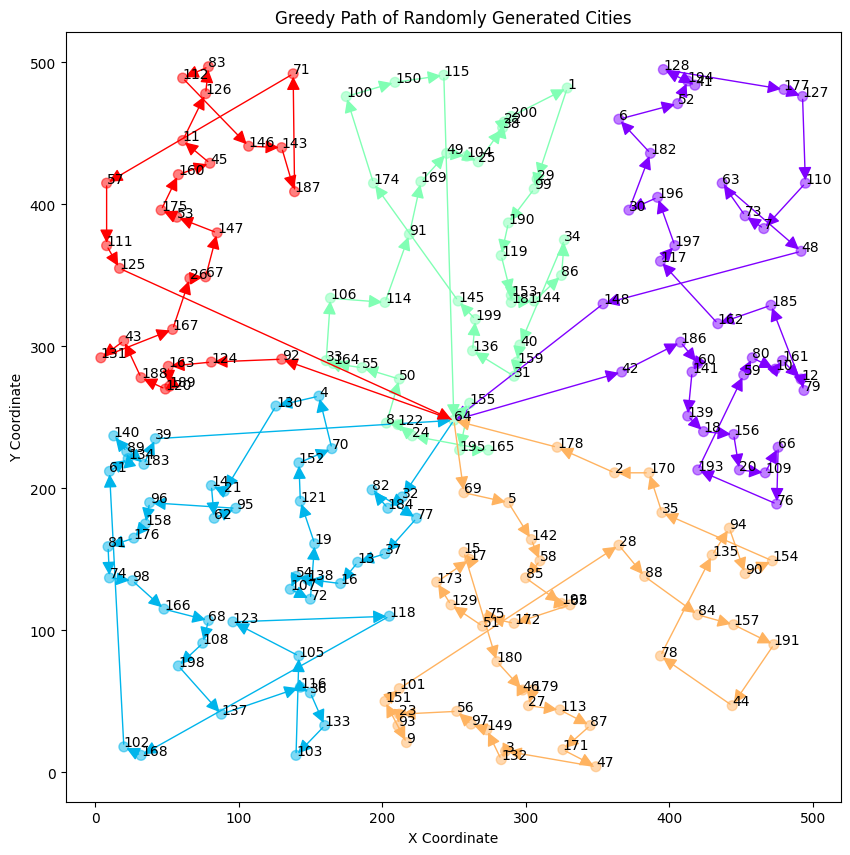

Total distance: 7810.472943238454


In [7]:
class Greedy:
    def __init__(self, cities: Any) -> None:
        """
        Initialize the Greedy object with city information.

        :param cities: Instance containing city information and methods to calculate distances.
        """
        self.cities = cities

    def __greedyPath(self, nodes: list[tuple[str, int, int]], start: str) -> tuple[list[tuple[str, int, int]], float]:
        """
        Calculate the path using a greedy approach starting from a given point.

        :param nodes: List of tuples representing cities in the form (name, x-coordinate, y-coordinate).
        :param start: Starting city.
        :return: Tuple containing the calculated path as a list and the total distance traveled.
        """
        # Convert nodes to a dictionary for quick access
        self.nodes = {node[0]: (node[1], node[2]) for node in nodes}
        visited = set()
        unvisited = set(self.nodes.keys())
        path = [(start, *self.nodes[start])]
        current = start
        visited.add(current)
        unvisited.remove(current)
        total_distance = 0

        while unvisited:
            next_node = None
            min_distance = float('inf')
            # Find the closest unvisited city
            for node in unvisited:
                distance = self.cities.calculateDistance(current, node)
                if distance < min_distance:
                    min_distance = distance
                    next_node = node
            total_distance += min_distance
            current = next_node
            path.append((current, *self.nodes[current]))
            visited.add(current)
            unvisited.remove(current)

        # Return to the starting city to complete the cycle
        path.append((start, *self.nodes[start]))
        total_distance += self.cities.calculateDistance(current, start)
        return path, total_distance

    def processClusters(self, cities_clusters: list[list[tuple[str, int, int]]], center_city: str) -> tuple[list[list[tuple[str, int, int]]], float]:
        """
        Process clusters of cities and calculate the greedy path for each cluster.

        :param cities_clusters: List of clusters, each cluster being a list of tuples (name, x-coordinate, y-coordinate).
        :param center_city: The central city to include in each cluster.
        :return: Tuple containing the greedy paths for each cluster and the total distance traveled.
        """
        cluster_greedy_path = []
        total_distance = 0
        for cluster_idx, cluster in enumerate(cities_clusters):
            if center_city in cluster:
                cluster.remove(center_city)
            cluster.append(center_city)
            path, distance = self.__greedyPath(cluster, cluster[-1][0])
            cluster_greedy_path.append(path)
            total_distance += distance
        return cluster_greedy_path, total_distance

# Usage
greedy_solver = Greedy(data)
cluster_greedy_paths, total_distance = greedy_solver.processClusters(cities_clusters, center_city)
graph = Graph(data=data.cities, title="Greedy Path of Randomly Generated Cities")
graph.scatter_plot(c=clusters, cmap='rainbow', s=50, alpha=0.5, arrow=cluster_greedy_paths)

print(f"Total distance: {total_distance}")


IntProgress(value=0, layout=Layout(width='100%'), max=800)

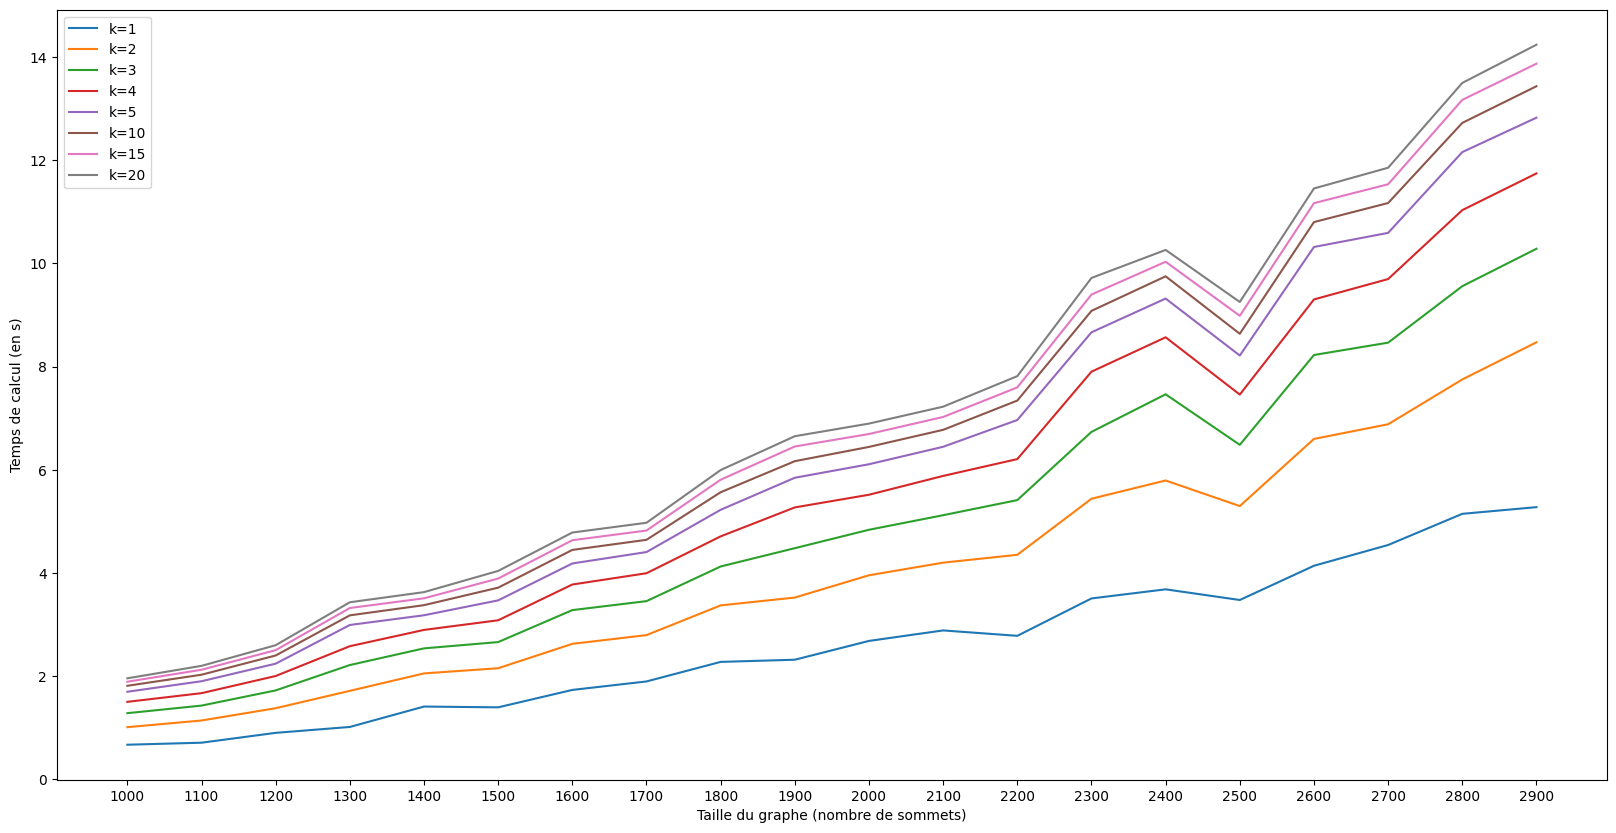

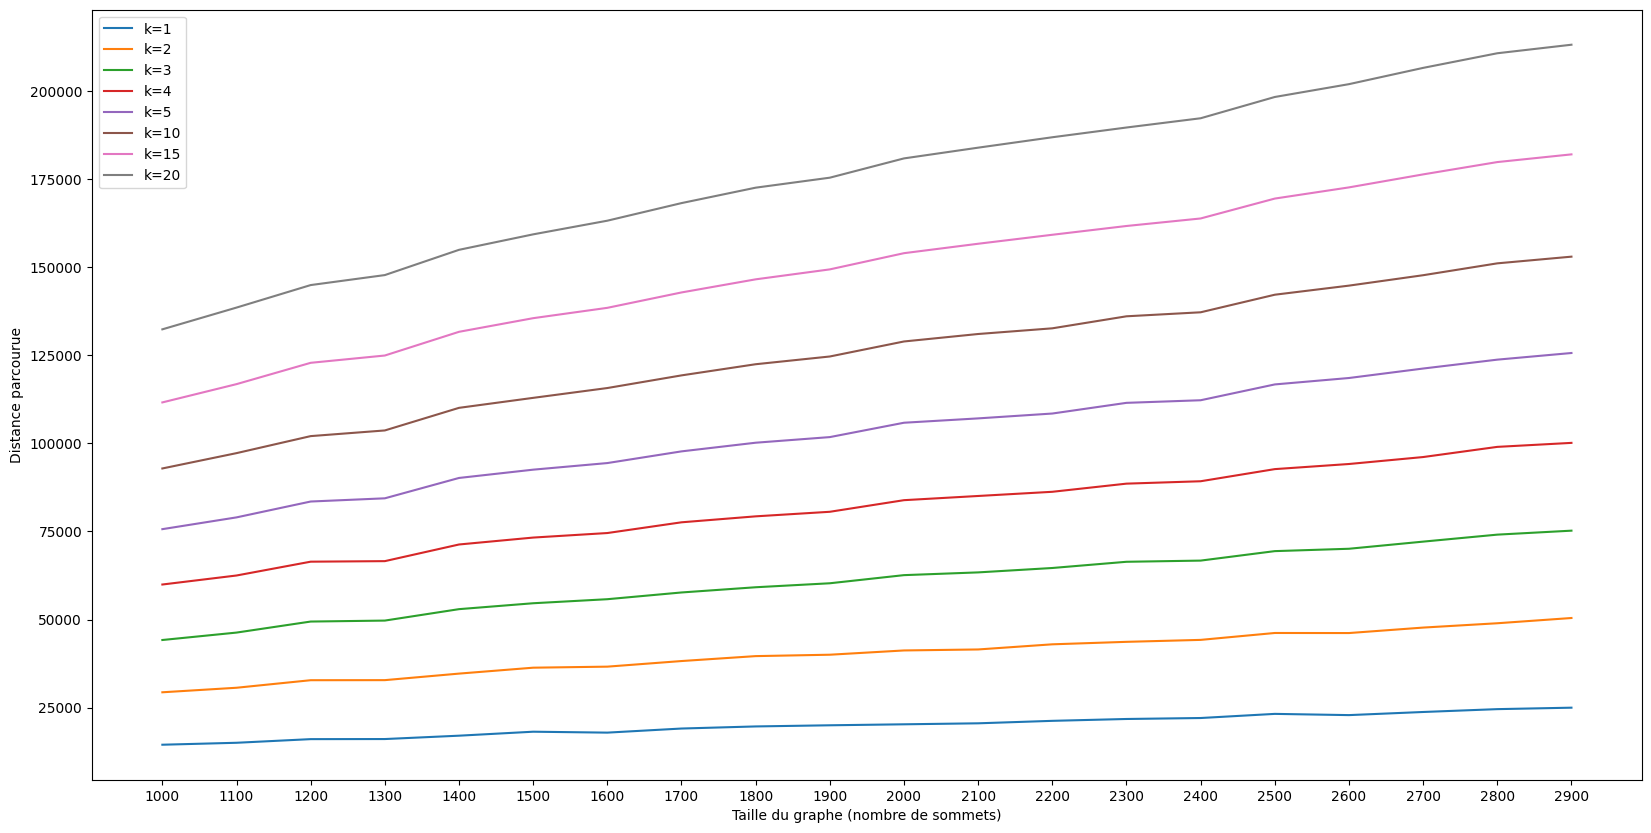

In [8]:
nb_iteration = 5
taille_min   = 1000
taille_max   = 3000
taille_step  = 100
k_values     = [1, 2, 3, 4, 5, 10, 15, 20]

# Create an array to store durations in function of the size of the graph and the k value
durees = np.zeros((len(k_values), (taille_max - taille_min) // taille_step))
distances = np.zeros((len(k_values), (taille_max - taille_min) // taille_step))

# on affiche la barre de progression
nb_tests = ((taille_max - taille_min) / taille_step) * nb_iteration * len(k_values)
bar = IntProgress(min=0, max=nb_tests, layout={"width" : "100%"})
display(bar)

for taille in range(taille_min, taille_max, taille_step):
    duree_moy   = 0.0
    distance_moy = 0.0
    for k in k_values:
        for i in range(nb_iteration):
            greedy_data = Cities(taille, x_range, y_range)
            center_city = greedy_data.getCenterCity()
            k_means = kMeansClusters(k, greedy_data.cities)
            clusters = k_means.getClusters()
            cities_clusters = k_means.getCitiesByCluster()
            greedy_solver = Greedy(greedy_data)
            start = time.time()
            cluster_greedy_paths, total_distance = greedy_solver.processClusters(cities_clusters, center_city)
            stop = time.time()
            duree = stop - start

            duree_moy += duree
            distance_moy += total_distance
            bar.value += 1

        durees[k_values.index(k)][(taille - taille_min) // taille_step] = duree_moy / nb_iteration
        distances[k_values.index(k)][(taille - taille_min) // taille_step] = distance_moy / nb_iteration
# on cache la barre de progression
bar.close()

# on règle l'affichage des courbes
tailles = [x for x in range(taille_min, taille_max, taille_step)]
plt.figure(figsize=(20,10))

plt.xlabel('Taille du graphe (nombre de sommets)')
plt.xticks(ticks=tailles) # valeurs affichées sur l'axe X
plt.ylabel('Temps de calcul (en s)')
plt.title('')
for i in range(len(k_values)):
    plt.plot(tailles, durees[i], label=f'k={k_values[i]}')

# on affiche
plt.legend()
plt.show()

plt.figure(figsize=(20,10))

plt.xlabel('Taille du graphe (nombre de sommets)')
plt.xticks(ticks=tailles) # valeurs affichées sur l'axe X
plt.ylabel('Distance parcourue')
plt.title('')
for i in range(len(k_values)):
    plt.plot(tailles, distances[i], label=f'k={k_values[i]}')

# on affiche
plt.legend()
plt.show()